# Eigenface recognition

## Data
The dataset provided by [CASIA](http://biometrics.idealtest.org/#/datasetDetail/9) consists of 4 faces image for each person. In my case I used just the first hundred faces, so the starting dataset is composed by 400 images belonging to 100 different persons.

## Eigenfaces extraction
Before doing the eigenfaces recognition there is the need to extract them starting from the face's images. To do so I followed the method proposed by [Tuck and Pentland](https://www.cin.ufpe.br/~rps/Artigos/Face%20Recognition%20Using%20Eigenfaces.pdf) and did it in order to obtain different size of the feature vector. In fact, each face has been extracted to a .txt file, in order to have *k* eigenfaces, where *k* = {1...12}. This will allow to make different calculation of the accuracy score and to choose the best compromise beetween accuracy and computation complexity.

## Data preparation
All the 400 eigenfaces with same feature vector lenght are stored in the correspondent folder, but in order to compute the recognition algorithm and see its performances the dataset is split into training and test sets, with ratio 30:10. Therefore the training set simulates the server database in which are stored 3 eigenfaces for each user, while the test set it's used to simulate the authentication request of an user trying to access a service.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from utils_eigenface import *
from sklearn.metrics import accuracy_score, precision_score, f1_score

In [2]:
train_images = get_all_eigenface('train', 1)
test_images = get_all_eigenface('test', 1)
print("Size of the training set: ", len(train_images))
print("Size of the training set: ", len(test_images))

Size of the training set:  300
Size of the training set:  100


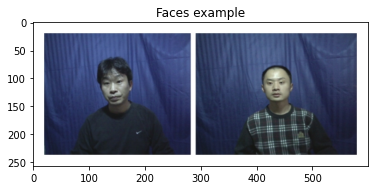

Feature vector with 5 eigenfaces: 
 [-10278, 1773, -2866, -711, -1153]


In [3]:
img = mpimg.imread('sample.png')
plt.imshow(img)
plt.title('Faces example')
plt.show()
print('Feature vector with 5 eigenfaces: \n', read_from_file_eigenface('eigenfaces/5/test/CASIA_5__0_0.txt'))

## Results analysis
For each feature vector in the test folder let's see how it performs when compared to all other located in the train folder. 
Starting from a test feature vector it will compute the squared Euclidean distance from every single train vector and also the mean distance from the 3 vectors available for every person in the train set. 

In [4]:
def result_analysis(size):
    total_mean = 0
    same_dist = 0
    diff_dist = 0
    different = 0
    same = 0
    train_images = get_all_eigenface('train', size)
    test_images = get_all_eigenface('test', size)
    
    for test in test_images:
        test_eigenface = read_from_file_eigenface(test)
        total_dist = 0
        count = 0
        for train in train_images:
            train_eigenface = read_from_file_eigenface(train)
            dist = squared_euclidean_distance(test_eigenface, train_eigenface)
            total_dist += dist
            count += 1
            if get_eigenface_class(test) == get_eigenface_class(train):
                same_dist += dist
                same += 1
            else:
                diff_dist += dist
                different += 1
            print('Dist from {} to {} is {}'.format(test, train, round(dist)))
            if count == 3:
                count = 0
                mean = total_dist/3
                total_dist = 0
                print('***********************************************************')
                print('Mean dist from {} to all {} is {}'.format(test, get_eigenface_class(train), round(mean)))
                print('***********************************************************')

    print('---------------------------------------------------------------')
    print('Mean for same fingerprints = {}, for different ones = {}'.format(round(same_dist/same), round(diff_dist/different)))
    return 

# uncomment the next line if necessary
#result_analysis(2)

From the above results it is possible to notice that when comparing eigenfaces from the same person the mean distance is 9025563 and that "good matches" are below 1000000, while the mean distance from the 3 wrong fingercodes is 193075600. These values are for the feature vector's whose length is 1.

## Identification scenario
In the following lines of code I defined the identification scenario, which corresponds to 1:M classification problem. It is usually applied when some entity needs to identify a person by acquiring its biometric and then searching in the database in order to correctly identify the person.
By executing the identification scenario every eigenface in the test set will be compared to each one in the train set and the prediction will be stored. 
This procedure can run with different threshold values for the squared Euclidean distance, in order to evaluate which one performs better.

In [5]:
def perform_authentication_scenario(threshold, size):
    y_true = []
    y_pred = []
    train_images = get_all_eigenface('train', size)
    test_images = get_all_eigenface('test', size)
    
    for test in test_images:
        test_eigenface = read_from_file_eigenface(test)
        total_dist = 0
        count = 0
        single_pred = []
        multiple_pred = []
        matched = 0
        y_true.append(get_eigenface_class(test))

        for train in train_images:
            count += 1
            train_eigenface = read_from_file_eigenface(train)
            dist = squared_euclidean_distance(test_eigenface, train_eigenface)
            total_dist += dist

            if dist < threshold:
                matched += 1
                if get_eigenface_class(train) not in single_pred:
                    single_pred.append(get_eigenface_class(train))
            
            if count == 3:
                count = 0
                total_dist = 0
                if matched >= 2:
                    multiple_pred.append(get_eigenface_class(train))
                matched = 0
        if len(multiple_pred) != 0:
            y_pred.append(multiple_pred[0])
        elif len(single_pred) != 0:
            y_pred.append(single_pred[0])
        else:
            y_pred.append('none')

    return y_true, y_pred

After preliminary analysis let's run the identification scenario from above with every feature vector's size that is available (from 1 to 12) with the correspondent best threshold and see how the accuracy changes.

Accuracy score for size 1 is 0.13
Precision score for size 1 is 0.13
F1 score for size 1 is 0.13
-------------------------------------------------
Accuracy score for size 2 is 0.41
Precision score for size 2 is 0.41
F1 score for size 2 is 0.41
-------------------------------------------------
Accuracy score for size 3 is 0.46
Precision score for size 3 is 0.46
F1 score for size 3 is 0.46
-------------------------------------------------
Accuracy score for size 4 is 0.57
Precision score for size 4 is 0.57
F1 score for size 4 is 0.57
-------------------------------------------------
Accuracy score for size 5 is 0.64
Precision score for size 5 is 0.64
F1 score for size 5 is 0.64
-------------------------------------------------
Accuracy score for size 6 is 0.65
Precision score for size 6 is 0.65
F1 score for size 6 is 0.65
-------------------------------------------------
Accuracy score for size 7 is 0.69
Precision score for size 7 is 0.69
F1 score for size 7 is 0.69
---------------------

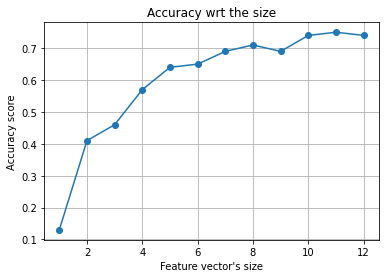

In [6]:
thresholds = [250000, 1100000, 1450000, 4600000, 5600000, 5500000, 9600000, 8700000, 10200000, 12400000, 12500000, 12600000]
accuracies = []
sizes = []

for size, threshold in zip(range(1, 13), thresholds):
    sizes.append(size)
    y_true, y_pred = perform_authentication_scenario(threshold, size)
    print('Accuracy score for size {} is {}'.format(size, round(accuracy_score(y_true, y_pred), 4)))
    print('Precision score for size {} is {}'.format(size, round(precision_score(y_true, y_pred, average='micro'), 4)))
    print('F1 score for size {} is {}'.format(size, round(f1_score(y_true, y_pred, average='micro'), 4)))
    print('-------------------------------------------------')
    accuracies.append(round(accuracy_score(y_true, y_pred), 4))
    
plt.plot(sizes, accuracies, marker='o')
plt.title('Accuracy wrt the size')
plt.xlabel("Feature vector's size")
plt.ylabel('Accuracy score')
plt.grid(True)
plt.show()   

It is possible to observe that the higher accuracy is obatained when the size is 11, but good accuracies are obtained also with size 8, 10 and 12.